In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error, accuracy_score
from numba import njit

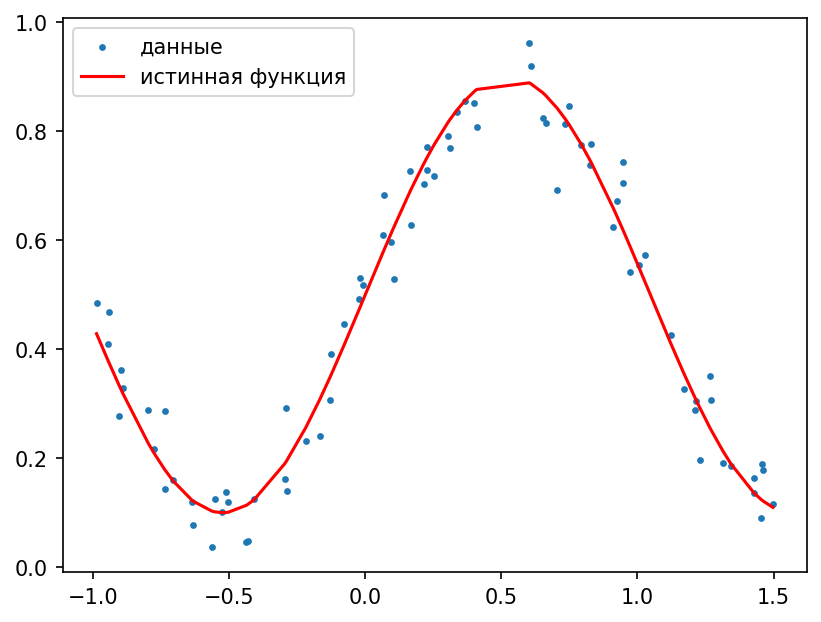

In [25]:
# размер выборки
sample_volume = 80
# обучающая выборка
x = np.random.uniform(-1, 1.5, (sample_volume,1))
y_true = np.sin(3*x)/2.5 + 0.5
y = y_true + np.random.normal(0, 0.05, (sample_volume,1))

fig, ax = plt.subplots(dpi=150)
ax.scatter(x, y, s=5, label = 'данные')
ax.plot(np.sort(x, axis=0), y_true[np.argsort(x, axis=0).flatten()], color='red', label = 'истинная функция')
ax.legend()
plt.show()

In [26]:
x.shape


(80, 1)

In [27]:
@njit
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [31]:
nn = NeuralNetwork([NeuralLayer(1, 3), 
                    NeuralLayer(3, 2), 
                    Output(2, 1)])

for i in range(50000):
    nn.epoch(x, y)

    if i % 1000 == 0:
        print(f"epoch={i}, loss={mean_squared_error(y, nn.layers[-1].output)}")


fig, ax = plt.subplots(dpi=150)
ax.scatter(x, y, s=5, label = 'данные')
plt.scatter(x, nn.layers[-1].output, s=7, label = 'выход НС')
ax.plot(np.sort(x, axis=0), y_true[np.argsort(x, axis=0).flatten()], 
        color='red', label = 'истинная функция')
ax.legend()
plt.show()
plt.show()

ValueError: shapes (80,2) and (1,3) not aligned: 2 (dim 1) != 1 (dim 0)

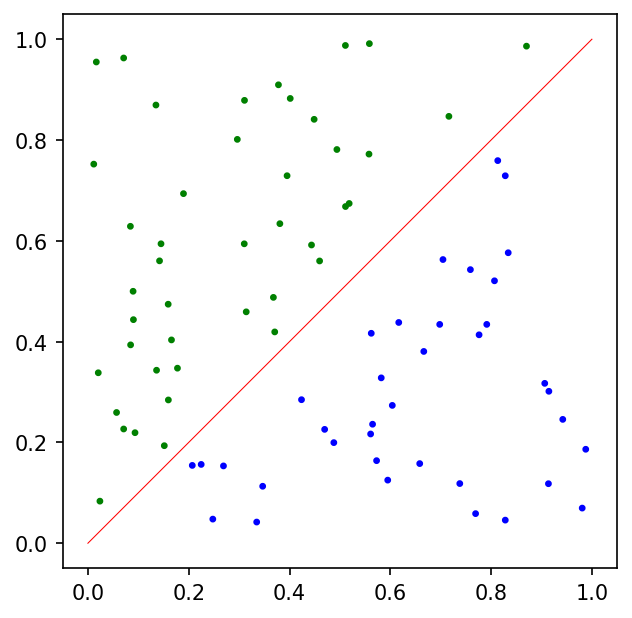

,x1,x2,y1,y2,class
0,0.020559,0.338175,1,0,0
1,0.159272,0.474209,1,0,0
2,0.136195,0.343218,1,0,0
3,0.716250,0.846966,1,0,0
4,0.564812,0.236113,0,1,1


In [28]:
sample_volume_2 = 80
x1 = np.random.uniform( 0, 1, (sample_volume_2,1) )
x2 = np.random.uniform( 0, 1, (sample_volume_2,1) )
y1 = np.zeros( (sample_volume_2,1) )
y2 = np.zeros( (sample_volume_2,1) )
y1 = np.where( x1>x2, 0, 1) # класс 1
y2 = np.where( x1>x2, 1, 0) # класс 0

fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.scatter(x1, x2, s=5, c=np.where(y1, 'green', 'blue').flatten())
ax.plot([0,1], [0,1], lw=0.5, color='red')
plt.show()
data = pd.DataFrame( {'x1': x1.flatten(), 'x2':x2.flatten(),
                      'y1':y1.flatten(), 'y2':y2.flatten(),
                      'class': y2.flatten()} )
data.head()

epoch = 1  Accuracy = 0.4625 Loss = 0.6932280463314523
epoch = 1000  Accuracy = 1.0 Loss = 0.0008062908274033982
epoch = 2000  Accuracy = 1.0 Loss = 0.00024444831147992326
[0 0 0]


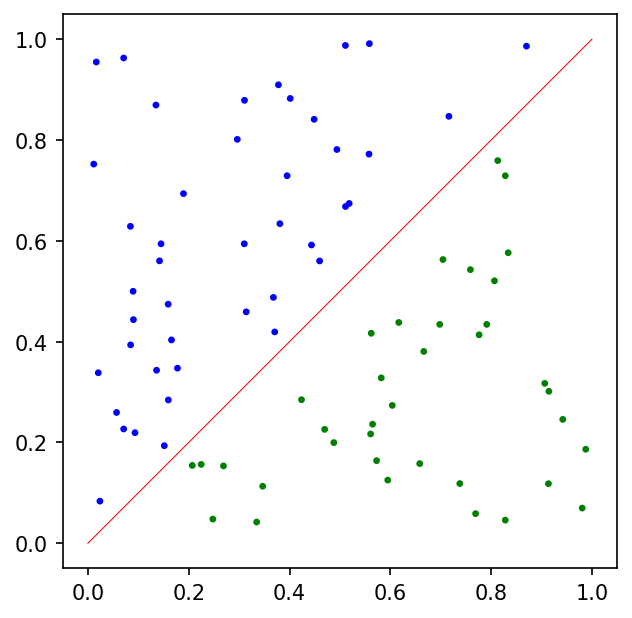

In [30]:
class NeuralLayer:
    def __init__(self, n_inputs, n_neurons):
        self.weights = 0.10 * np.random.uniform(-1, 1, (n_inputs + 1, n_neurons))

    # @njit
    def forward(self, x):
        self.input = np.hstack((x, np.ones((x.shape[0], 1))))
        self.output = sigmoid(np.dot(x, self.weights[:-1, :]) + \
                              self.weights[-1, :])
        self.derivatives =  self.output * (1 - self.output)

    def backward(self, delta_next, weights_next):
        self.delta = np.dot(delta_next, weights_next.T)[:, :-1] * self.derivatives

    def update_weights(self, learning_rate: float = 0.1):
        self.weights -= learning_rate * np.dot(self.input.T, self.delta)


class Output(NeuralLayer):
    def backward(self, target):
        self.delta = (self.output - target) * self.derivatives

class SoftMax(NeuralLayer):

    @staticmethod
    def softmax(x):
        exp_shifted = np.exp(x - x.max(axis=1).reshape(-1,1))
        return exp_shifted / np.sum(exp_shifted, axis=1).reshape(-1,1)

    def forward(self, x):
        self.input = np.hstack((x, np.ones((x.shape[0], 1))))
        self.output = self.softmax(np.dot(self.input, self.weights))
        self.derivatives =  self.output * (1 - self.output)

    def backward(self, target):
        self.delta = self.output - target



class NeuralNetwork:
    def __init__(self, layers: list[NeuralLayer]):
        self.layers = layers

    def forward(self, x):
        for layer in self.layers:
            layer.forward(x)
            x = layer.output
        return self.layers[-1].output

    def backward(self, target):
        self.layers[-1].backward(target)
        for i, layer in enumerate(reversed(self.layers[:-1])):
            layer.backward(self.layers[-1-i].delta, self.layers[-1-i].weights)
        for layer in self.layers:
            layer.update_weights()

    def epoch(self, x, target):
        self.forward(x)
        self.backward(target)



nn = NeuralNetwork([NeuralLayer(2, 10),
                    NeuralLayer(10, 5),
                    SoftMax(5, 2)])

x = data[['x1','x2']]
y = data[['y1', 'y2']].values

for i in range(2000):
    nn.epoch(x, y)

    if (i+1) % 1000 == 0 or i == 0:
        prediction = np.argmax(nn.layers[-1].output, axis=1)
        accuracy = accuracy_score(prediction, data['class'])
        loss = np.mean(-1 * np.sum( y * np.log(nn.layers[-1].output), 
                                   axis=1 ).reshape(-1,1))
        print("epoch =", i+1, " Accuracy =", accuracy, "Loss =", loss )

prediction = np.argmax(nn.layers[-1].output, axis=1)
print(prediction[:3])
fig, ax = plt.subplots(dpi=150)
ax.set_aspect('equal')
ax.scatter(x1, x2, s=5, c=np.where(prediction, 'green', 'blue').flatten())
ax.plot([0,1], [0,1], lw=0.5, color='red')
plt.show()

In [ ]:
np.conv